<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Binary_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data to train

In [1]:
!nvidia-smi

Wed Nov  4 23:14:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone --depth 1 https://github.com/Vengadore/Segmentation_OPTOS.git

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 1), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [3]:
# Download dataset
from IPython.display import clear_output
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1"
!sudo chmod 777 "EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1"
!mv "EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1" "PDR.zip"
!unzip PDR.zip
!rm PDR.zip
clear_output(wait=False)

print("Data downloaded")

Data downloaded


In [16]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 2.8MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [17]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=83b558d55e7efdfe08533bb45030fc51a6deb9eb074d3f949f7bfd21d4f8b99f
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [1]:
from Segmentation_OPTOS.Tools.Annotations.Formats import VOC_format_V2
from Segmentation_OPTOS.Tools.Generators.BoundingB import createBackgroundBB
import os
import cv2
import numpy as np

In [2]:
path = "./"
dirs = os.listdir(path)
# Annotations
path_ann = os.path.join(path,"Annotations")
# ImageSets
path_sets = os.path.join(path,"ImageSets/")
# Images
path_imgs = os.path.join(path,dirs[2])

In [3]:
#Training set
with open(os.path.join(path_sets,'train.txt'),'r') as f:
    train = f.read().split('\n')[:-1]
#Validation set
with open(os.path.join(path_sets,'trainval.txt'),'r') as f:
    val = f.read().split('\n')[:-1]

In [4]:
train_ann = [os.path.join(path_ann,Ann+'.xml') for Ann in train]#[os.path.join(path_ann,Ann) for Ann in os.listdir(path_ann)]
val_ann = [os.path.join(path_ann,Ann+'.xml') for Ann in val]

In [5]:
from Segmentation_OPTOS.Tools.Annotations.view import show_annotations

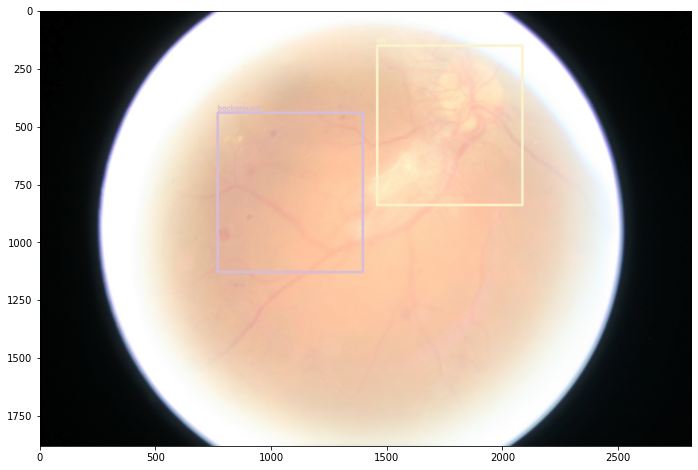

In [6]:
Ann = VOC_format_V2(train_ann[0])
createBackgroundBB(Ann)
show_annotations(Ann,"./train/")

## Set model and training parameters

In [7]:
from model import *

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = binary_model(number_classes=1)
Model.to(device);

Loaded pretrained weights for efficientnet-b7


In [9]:
import torch
import torch.optim as optim
from PIL import Image
from torchvision.transforms import Compose,Normalize,RandomHorizontalFlip
from torchvision.transforms import RandomRotation,RandomVerticalFlip,ToTensor,Resize

torch.manual_seed(17)


transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),RandomRotation(60)])
normalization = Compose([ToTensor(),
                         Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

criterion = nn.BCELoss()
optimizer = optim.SGD(Model.parameters(), lr=0.0001, momentum=0.9)

In [10]:
total_ann = sum([len(Ann.objects) for an in train_ann])
total_ann

336

In [11]:
from tqdm import tqdm
import random
def get_box(obj):
    return (int(obj.find('xmin').text),int(obj.find('ymin').text),int(obj.find('xmax').text),int(obj.find('ymax').text))

epochs = 100
classes = {'NV':[1],'background':[0]}
patches_shape = (412,412)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    pbar = tqdm(sorted(iter(train_ann), key=lambda k: random.random()),ncols = 100,)
    running_loss = 0.0
    running_acc = 0.0
    t = 0
    for step in pbar:
        # Load data
        Ann = VOC_format_V2(step)
        img = Image.open(os.path.join("./train",Ann.get_attribute('filename')))
        
        #According to the number of objects (Vessels) create background boxes
        for i in range(len(Ann.objects)):
            createBackgroundBB(Ann)
        # Extract patch
        x_batch = torch.FloatTensor().to(device)
        y_batch = torch.FloatTensor().to(device)
        for i,patch in enumerate(sorted(iter(Ann.objects), key=lambda k: random.random())):
            if i>4:
                break
            P = img.crop(get_box(patch.find('bndbox'))).resize(patches_shape)
            P = transforms(P)
            P = normalization(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))
            name = patch.find('name').text
            y_batch = torch.cat((y_batch,torch.FloatTensor(classes[name]).unsqueeze(0).to(device)))
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = Model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += y_batch.shape[0]
        running_acc += torch.sum(y_batch.gt(0.5) == outputs.gt(0.5)).cpu().detach().numpy()
        acc = torch.sum(y_batch.gt(0.5) == outputs.gt(0.5)).cpu().detach().numpy()/y_batch.shape[0];
        pbar.set_description("Accuracy: {:0.2f} Loss: {:0.2f} ".format(running_acc/t,running_loss/t))
        
        


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 1


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 2


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 3


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 4


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 5


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 6


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 7


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 8


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 9


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 10


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 11


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 12


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 13


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 14


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 15


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 16


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 17


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 18


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 19


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 20


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 21


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 22


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 23


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 24


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 25


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 26


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 27


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 28


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 29


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 30


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 31


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 32


Accuracy: 0.92 Loss: 0.05 :   9%|███                               | 15/168 [00:08<01:31,  1.68it/s]

KeyboardInterrupt: ignored

In [15]:
torch.save(Model,'Patches.ph')

In [14]:
y_batch.shape[0]+2

4

In [ ]:
next(iter(train_ann))

In [ ]:
I = x_batch[1].cpu().detach().permute(1,2,0).numpy()
import matplotlib.pyplot as plt
plt.imshow(I)